In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import newton_krylov
from time import clock as clock

Conservation law

$$ \partial_t c(x,t) = - \partial_x ( -D c \partial_x f ) $$

time and spatial nondimensionalization

$$ t = \frac{ \tilde{t} }{ T_0 } $$
$$ x = \frac{ \tilde{x} }{ L }  $$
$$ D = \frac{ \tilde{D} }{ D_0 } $$

Reference Time

$$ T_0 = M \cdot \frac{L^2}{D_0} $$

Plug in

$$ \frac{1}{T_0} \partial_t c(x,t) = - \frac{D_0}{L^2} \partial_x ( -D c \partial_x g ) $$

$$ \frac{D_0}{ML^2}\partial_t c(x,t) = - \frac{D_0}{L^2} \partial_x ( -D c \partial_x g ) $$

$$ \partial_t c(x,t) = - M \partial_x ( -D c \partial_x g ) $$

Discretization scheme

$$ \frac{ c_{i,j} - c_{i,j-1} }{\Delta t} + M \frac{1}{\Delta x_i} \left( f_{i+1} - f_i \right) = 0 $$

$$ c_{i,j} - c_{i,j-1} + M \frac{\Delta t}{\Delta x_i} \left( f_{i+1} - f_i \right) = 0 $$

evaluation at boundary points at left cell edge $i$ and right edge $i+1$.

velocity through derivative of driving field approximated by central difference.

$$ v_i = - \partial_x g(x_i) \approx - \frac{ 2(g_i - g_{i-1}) }{ \Delta x_i + \Delta x_{i-1} } $$
$$ v_{i+1} = - \partial_x g(x_{i+1}) \approx - \frac{ 2(g_{i+1} - g_{i}) }{ \Delta x_{i+1} + \Delta x_{i} } $$

fluxes with upwinding

$$ f_{i,j} = D_{i}v_i \cdot \begin{cases}
c_{i-1,j} & ,\text{if }v_i>0\\
c_{i,j} & ,\text{if }v_i\leq0
\end{cases} $$

$$ f_{i+1,j} = D_{i+1}v_{i+1} \cdot \begin{cases}
c_{i,j} & ,\text{if }v_i>0\\
c_{i+1,j} & ,\text{if }v_i\leq0
\end{cases} $$

Jacobian construction

derivation through concentrations

$$ \partial_{c_m} \left[ c_{i,j} - c_{i,j-1} + M \frac{\Delta t}{\Delta x_i} \left( f_{i+1,j} - f_{i,j} \right) \right] $$

$$ \delta_{m,i} + M \frac{\Delta t}{\Delta x_i} \left( \partial_{c_m} f_{i+1,j} - \partial_{c_m} f_{i,j} \right) $$

Derivatives of upwinding fluxes

$$ \partial_{c_m} f_{i+1,j} = D_{i+1}v_{i+1} \cdot \begin{cases}
\partial_{c_m} c_{i,j} & ,\text{if }v_{i+1}>0\\
\partial_{c_m} c_{i+1,j} & ,\text{if }v_{i+1}\leq0
\end{cases} = D_{i+1}v_{i+1} \cdot \begin{cases}
\delta_{m,i} & ,\text{if }v_{i+1}>0\\
\delta_{m,i+1} & ,\text{if }v_{i+1}\leq0
\end{cases} $$

$$ \partial_{c_m} f_i{i,j} = D_{i}v_i \cdot \begin{cases}
\partial_{c_m} c_{i-1,j} & ,\text{if }v_i>0\\
\partial_{c_m} c_{i,j} & ,\text{if }v_i\leq0
\end{cases} = D_{i}v_i \cdot \begin{cases}
\delta_{m,i-1} & ,\text{if }v_i>0\\
\delta_{m,i} & ,\text{if }v_i\leq0
\end{cases} $$

Putting things together

$$ \delta_{m,i} + M \frac{\Delta t}{\Delta x_i} \left( D_{i+1}v_{i+1} \cdot \begin{cases}
\delta_{m,i} & ,\text{if }v_{i+1}>0\\
\delta_{m,i+1} & ,\text{if }v_{i+1}\leq0
\end{cases} - D_{i}v_i \cdot \begin{cases}
\delta_{m,i-1} & ,\text{if }v_i>0\\
\delta_{m,i} & ,\text{if }v_i\leq0
\end{cases} \right) $$

Tridiagonal matrix

$$ A_{i,i-1} = -M \frac{\Delta t}{\Delta x_i} D_i v_i \text{, if } v_i > 0 $$

$$ A_{i,i} = 1 + M \frac{\Delta t}{\Delta x_i} \left( D_{i+1}v_{i+1} \left[ \text{ if } v_{i+1} > 0 \right] - D_i v_i  \left[ \text{ if } v_{i} \leq 0 \right] \right) $$

$$ A_{i,i+1} = M \frac{\Delta t}{\Delta x_i} D_{i+1} v_{i+1} \text{, if } v_{i+1} \leq 0 $$



At the boundaries:

At left boundary $ i = 0 $:

$$ A_{0,0} = 1 + M \frac{\Delta t}{\Delta x_0} D_{1} v_1 \text{, if } v_1 > 0 $$

$$ A_{0,1} = M \frac{\Delta t}{\Delta x_0} D_{1} v_1 \text{, if } v_1 \leq 0 $$

At right boundary $ i = I-1 $:

$$ A_{I-1,I-2} = -M \frac{\Delta t}{\Delta x_{I-1} } D_{I-1} v_{I-1} \text{, if } v_{I-1} > 0 $$

$$ A_{I-1,I-1} = 1 - M \frac{\Delta t}{\Delta x_{I-1} } D_{I-1} v_{I-1} \text{, if } v_{I-1} \leq 0 $$

In [ ]:
# calculate Jacobian
@jit(  float64[:,:](int32, float64, float64, float64[:], float64[:], float64[:]) )
def Jacobian( I, M, Dt, D, Dx, g ):
    
    A = np.zeros([I,I], dtype = np.float64 )

    # v_i = veldown; v_i+1 = veldown
    
    # calculate velocities
    velup = -2.0 * (g[1] - g[0]) / (Dx[1] + Dx[0])
    
    # left boundary
    A[0,0] = 1
    
    if velup > 0:
        A[0,0] += M * Dt * D[1] * velup / Dx[0]
    else:
        A[0,1] = M * Dt * D[1] * velup / Dx[0]

    # inner points
    for i in range(1,I-1):
        
        
        
        A[i,i] = 1
        
        # calculate velocities
        veldown = -2.0 * (g[i] - g[i-1]) / (Dx[i] + Dx[i-1])
        velup = -2.0 * (g[i+1] - g[i]) / (Dx[i+1] + Dx[i])
        
        if veldown > 0:
            A[i,i-1] = -M * Dt * D[i] * veldown / Dx[i]
        else: # veldown <= 0
            A[i,i] += -M * Dt * D[i] * veldown / Dx[i]

        if velup <= 0:
            A[i,i+1] = M * Dt * D[i+1] * velup / Dx[i]
        else: # velup > 0
            A[i,i] += M * Dt * D[i+1] * velup / Dx[i]


    # right boundary
    A[I-1,I-1] = 1.0
    
    # calculate velocities
    veldown = - 2.0 * (g[I-1] - g[I-2]) / (Dx[I-1] + Dx[I-2])
        
    if veldown > 0:
        A[I-1,I-2] = -M * Dt * D[I-1] * veldown / Dx[I-1]
    else:
        A[I-1,I-1] += -M * Dt * D[I-1] * veldown / Dx[I-1]
        
    return A

@jit(  float64[:](float64[:], float64[:], float64[:], float64[:], float64[:], int32, float64, float64),
        nopython= False )
def residual(sol_old, sol_new, g, Dx, D, I, Dt, M):
    """
    Implemented periodic boundary conditions
    """
    res = np.zeros(I, dtype = np.float64)
    
    #
    # Godunov scheme
    #
    
    veldown =  -2.0 * (g[1] - g[0]) / (Dx[1] + Dx[0]) # periodic
    velup = - 2.0 * (g[1] - g[0]) / (Dx[1] + Dx[0])  # velocity on right cell edge
    
    if veldown > 0:

            downflux = veldown * D[0] * sol_new[I-1]

    else:

            downflux = veldown * D[0] * sol_new[0]
            
    if velup >= 0:

        upflux = velup * D[1] * (sol_new[0]  )

    else:

        upflux = velup * D[1] * sol_new[1]
    
    # anode boundary condition
    res[0] = (sol_new[0] - sol_old[0] + M * Dt * (upflux - downflux) / Dx[0])

    # inner points
    for i in range(1,I-1):
        
        #
        # Godunov scheme - upwinding with (unlimited !) piecewise constant reconstruction
        #
        
        # calculate velocity - driving electric field
        velup = - 2.0 * (g[i+1] - g[i]) / (Dx[i+1] + Dx[i]) # velocity on right cell edge
        veldown = - 2.0 * (g[i] - g[i-1]) / (Dx[i] + Dx[i-1]) # velocity on left cell edge
        
        # code flux limiter directly into the conditional statements
        
        # choosing limiter following wikipedia
        #r = ( sol_new[i+1] - sol_new[i] ) / ( sol_new[i] - sol_new[i-1] )
      #  r = ( sol_new[i] - sol_new[i-1] ) * ( sol_new[i+1] - sol_new[i] )
        
        # limiter function
            
        #    limiter = 0.0
            
       # else:
            
            #
            
            # van Leer
            #limiter = 
            # minmod
            #limiter = np.max([0.0, np.min([1.0, r])])
            # superbee
            #limiter = np.max([0.0, np.min([2*r,1]), np.min([r, 2])])
            # MC
            #limiter = np.max([0, np.min([2*r,0.5*(1+r),2])])
        
        # flux at rigth cell edge
        # for reconstruction: slope is 2 * (c_i+1 - c_i) / (Dx_i+1 + Dx_i)
        #
        
        # switch between first order and second order with van leer limiter
        if (sol_old[i] - sol_old[i-1]) * (sol_old[i+1] - sol_old[i]) < 0:
            
            limiter = 0.0

        else:
            r = ( sol_old[i] - sol_old[i-1] ) / ( sol_old[i+1] - sol_old[i] )
            
            limiter = 2*r / ( 1.0 + r )
        
        if velup > 0:
            
            upflux = velup * D[i+1] * ( sol_new[i]
                     + Dx[i] * limiter * ( sol_new[i+1] - sol_new[i] ) / (Dx[i+1] + Dx[i]) )

        else:

            upflux = velup * D[i+1] * ( sol_new[i+1] 
                    - Dx[i+1]  * limiter * ( sol_new[i+1] - sol_new[i] ) / (Dx[i+1] + Dx[i]) )
        
        # flux at left cell edge
        if veldown > 0:
            
            downflux = veldown * D[i] * ( sol_new[i-1] 
                       + Dx[i-1] * limiter * (sol_new[i] - sol_new[i-1]) / (Dx[i] + Dx[i-1]) )

        else:
            
            
            downflux = veldown * D[i] * ( sol_new[i] 
                        - Dx[i] * limiter * (sol_new[i] - sol_new[i-1]) / (Dx[i] + Dx[i-1]) )
            
        res[i] = sol_new[i] -sol_old[i] + M * Dt * ( upflux - downflux ) / Dx[i]

    # velocity on f_left
    veldown = - 2.0 * (g[I-1] - g[I-2]) / (Dx[I-1] + Dx[I-2])
    velup = - 2.0 * (g[I-1] - g[I-2]) / (Dx[I-1] + Dx[I-2]) # periodic extrapolated other velocitiy
    
    if veldown > 0:

        downflux = veldown * D[I-1] * sol_new[I-2]

    else:

        downflux = veldown * D[I-1] * sol_new[I-1]
    
    if velup > 0:
            
            upflux = velup * D[I] * sol_new[I-1]

    else:

            upflux = velup * D[I] * sol_new[0]
            
    # catode boundary condition
    res[I-1] = (sol_new[I-1]- sol_old[I-1] + M * Dt * (upflux - downflux ) / Dx[I-1])
    
    return res

# solver method
def solver( I,
           N,
           initial_cond,
           Dx,
           Dt,
           M,
           g ):
    
    D = np.ones( I+1, dtype = np.float64 )
       
    
    
    # init solution vector
    sol = np.empty( [I,N], dtype = np.float64 )
    sol[:,0] = initial_cond[:]

    t1 = clock()

    # because the jacobian of this system is singular we use the pseudo inverse
    J = Jacobian( I, M, Dt, D, Dx, g )
    J_inv = np.linalg.inv(J)

    # time loop
    for j in range(1, N):

        if np.mod(j,100) == 0:
            print("Timestep ",j)
                                                
        sol[:,j] = newton_krylov( lambda y: residual(sol[:,j-1], y, g, Dx, D, I, Dt, M ), sol[:,j-1],
                                 verbose = 0, inner_M = J_inv)

    t2 = clock()

    print("Simulation Time: ", t2-t1)

    sim_time = t2-t1
    
    solint = np.zeros(N, dtype = np.float64)
    for j in range(N):
        solint[j] = np.dot(sol[:,j], Dx)
    
    return sol, sim_time, solint

In [ ]:
# time axis explicit integration
N = 1000
Dt = 3e-5
time = np.zeros(N, dtype = np.float64 )
for j in range(0, N):
    
    time[j] = j * Dt

I = 300
    
xi = np.arange(0.0, 1.0 + 1.0 / (I+1), 1.0 / (I) )
x = xi

# getting cell volumes
Dx = x[1:] - x[:I]

# initial condition
sigma = 0.005
centers = np.zeros(I, dtype = np.float64)
centers = x[:I] + (x[1:] - x[:I])
initial_cond = np.exp( -(centers - 0.5) ** 2 / (2 * sigma)  ) / (sigma * np.sqrt(2*np.pi))

# linear function as driving field defined also on cell centers
g = 2 * centers

M = 1e1

sol, sim_time, solint = solver( I, N, initial_cond, Dx, Dt, M, g )

fig = plt.figure(dpi = 120)

ax1 = fig.add_subplot(1,2,1)

ax1.plot(centers, sol)

#ax1.plot(centers, sol[:,-1], lw = 2, color = "red")

ax2 = fig.add_subplot(1,2,2)

#ax2.plot(time, solint)

plt.show()

In [98]:
from numba import jit, float64, int32, vectorize

In [99]:
@jit([ float64(float64[:], float64[:]) ])
def createVel( g, Dx):

    velup = np.empty(I, dtype = np.float64)
    veldown = np.empty(I, dtype = np.float64)
    
    for i in range(I):
        if i<I-1:
            velup[i] = - 2.0 * (g[i+1] - g[i]) / (Dx[i+1] + Dx[i]) # velocity on right cell edge
        if i>0:
            veldown[i] = - 2.0 * (g[i] - g[i-1]) / (Dx[i] + Dx[i-1])
    
    return velup, veldown

@vectorize([float64(float64, float64, float64, float64)])
def calc_velup( g_ip, g_i, Dx_ip, Dxi ):
    return - 2.0 * ( g_ip - g_i) / (Dx_ip + Dxi)

def calc_veldown( g_i, g_im, Dx_i, Dx_im):
    return -2.0 * (g_i - g_im) / (Dx_i + Dx_im)

In [100]:
a = np.array([1,3,5,7,9,10])
b = np.array([2,4,6,8,9,11])
c = np.empty(b.shape[0])

def 

a[1:]

array([3, 5, 7])

In [93]:
%%timeit
createVel(g,Dx)

45.6 µs ± 18.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [82]:
# calculate Jacobian
@jit(  float64[:,:](int32, float64, float64, float64[:], float64[:], float64[:]) )
def Jacobian( I, M, Dt, D, Dx, g ):
    
    A = np.zeros([I,I], dtype = np.float64 )

    # v_i = veldown; v_i+1 = veldown
    
    # calculate velocities
    velup = -2.0 * (g[1] - g[0]) / (Dx[1] + Dx[0])
    
    # left boundary
    A[0,0] = 1
    
    if velup > 0:
        A[0,0] += M * Dt * D[1] * velup / Dx[0]
    else:
        A[0,1] = M * Dt * D[1] * velup / Dx[0]

    # inner points
    for i in range(1,I-1):
        
        
        
        A[i,i] = 1
        
        # calculate velocities
        veldown = -2.0 * (g[i] - g[i-1]) / (Dx[i] + Dx[i-1])
        velup = -2.0 * (g[i+1] - g[i]) / (Dx[i+1] + Dx[i])
        
        if veldown > 0:
            A[i,i-1] = -M * Dt * D[i] * veldown / Dx[i]
        else: # veldown <= 0
            A[i,i] += -M * Dt * D[i] * veldown / Dx[i]

        if velup <= 0:
            A[i,i+1] = M * Dt * D[i+1] * velup / Dx[i]
        else: # velup > 0
            A[i,i] += M * Dt * D[i+1] * velup / Dx[i]


    # right boundary
    A[I-1,I-1] = 1.0
    
    # calculate velocities
    veldown = - 2.0 * (g[I-1] - g[I-2]) / (Dx[I-1] + Dx[I-2])
        
    if veldown > 0:
        A[I-1,I-2] = -M * Dt * D[I-1] * veldown / Dx[I-1]
    else:
        A[I-1,I-1] += -M * Dt * D[I-1] * veldown / Dx[I-1]
        
    return A

@jit(  float64[:](float64[:], float64[:], float64[:], float64[:], float64[:], int32, float64, float64),
        nopython= False )
def residual(sol_old, sol_new, g, Dx, D, I, Dt, M):
    """
    Implemented periodic boundary conditions
    """
    res = np.zeros(I, dtype = np.float64)
    
    #
    # Godunov scheme
    #
    
    veldown =  -2.0 * (g[1] - g[0]) / (Dx[1] + Dx[0]) # periodic
    velup = - 2.0 * (g[1] - g[0]) / (Dx[1] + Dx[0])  # velocity on right cell edge
    
    if veldown > 0:

            downflux = veldown * D[0] * sol_new[I-1]

    else:

            downflux = veldown * D[0] * sol_new[0]
            
    if velup >= 0:

        upflux = velup * D[1] * (sol_new[0]  )

    else:

        upflux = velup * D[1] * sol_new[1]
    
    # anode boundary condition
    res[0] = (sol_new[0] - sol_old[0] + M * Dt * (upflux - downflux) / Dx[0])

    # inner points
    for i in range(1,I-1):
        
        #
        # Godunov scheme - upwinding with (unlimited !) piecewise constant reconstruction
        #
        
        # calculate velocity - driving electric field
        velup = - 2.0 * (g[i+1] - g[i]) / (Dx[i+1] + Dx[i]) # velocity on right cell edge
        veldown = - 2.0 * (g[i] - g[i-1]) / (Dx[i] + Dx[i-1]) # velocity on left cell edge
          
        # switch between first order and second order with van leer limiter
        if (sol_old[i] - sol_old[i-1]) * (sol_old[i+1] - sol_old[i]) < 0:
            
            limiter = 0.0

        else:
            r = ( sol_old[i] - sol_old[i-1] ) / ( sol_old[i+1] - sol_old[i] )
            
            limiter = 2*r / ( 1.0 + r )
        
        if velup > 0:
            
            upflux = velup * D[i+1] * ( sol_new[i]
                     + Dx[i] * limiter * ( sol_new[i+1] - sol_new[i] ) / (Dx[i+1] + Dx[i]) )

        else:

            upflux = velup * D[i+1] * ( sol_new[i+1] 
                    - Dx[i+1]  * limiter * ( sol_new[i+1] - sol_new[i] ) / (Dx[i+1] + Dx[i]) )
        
        # flux at left cell edge
        if veldown > 0:
            
            downflux = veldown * D[i] * ( sol_new[i-1] 
                       + Dx[i-1] * limiter * (sol_new[i] - sol_new[i-1]) / (Dx[i] + Dx[i-1]) )

        else:
            
            
            downflux = veldown * D[i] * ( sol_new[i] 
                        - Dx[i] * limiter * (sol_new[i] - sol_new[i-1]) / (Dx[i] + Dx[i-1]) )
            
        res[i] = sol_new[i] -sol_old[i] + M * Dt * ( upflux - downflux ) / Dx[i]

    # velocity on f_left
    veldown = - 2.0 * (g[I-1] - g[I-2]) / (Dx[I-1] + Dx[I-2])
    velup = - 2.0 * (g[I-1] - g[I-2]) / (Dx[I-1] + Dx[I-2]) # periodic extrapolated other velocitiy
    
    if veldown > 0:

        downflux = veldown * D[I-1] * sol_new[I-2]

    else:

        downflux = veldown * D[I-1] * sol_new[I-1]
    
    if velup > 0:
            
            upflux = velup * D[I] * sol_new[I-1]

    else:

            upflux = velup * D[I] * sol_new[0]
            
    # catode boundary condition
    res[I-1] = (sol_new[I-1]- sol_old[I-1] + M * Dt * (upflux - downflux ) / Dx[I-1])
    
    return res

# solver method
def solver( I,
           N,
           initial_cond,
           Dx,
           Dt,
           M,
           g ):
    
    D = np.ones( I+1, dtype = np.float64 )
       
    
    
    # init solution vector
    sol = np.empty( [I,N], dtype = np.float64 )
    sol[:,0] = initial_cond[:]

    t1 = clock()

    # because the jacobian of this system is singular we use the pseudo inverse
    J = Jacobian( I, M, Dt, D, Dx, g )
    J_inv = np.linalg.inv(J)

    # time loop
    for j in range(1, N):

        if np.mod(j,100) == 0:
            print("Timestep ",j)
                                                
        sol[:,j] = newton_krylov( lambda y: residual(sol[:,j-1], y, g, Dx, D, I, Dt, M ), sol[:,j-1],
                                 verbose = 0, inner_M = J_inv)

    t2 = clock()

    print("Simulation Time: ", t2-t1)

    sim_time = t2-t1
    
    solint = np.zeros(N, dtype = np.float64)
    for j in range(N):
        solint[j] = np.dot(sol[:,j], Dx)
    
    return sol, sim_time, solint

Timestep  100
Timestep  200
Timestep  300
Timestep  400
Timestep  500
Timestep  600
Timestep  700
Timestep  800
Timestep  900
Simulation Time:  132.9990499999999


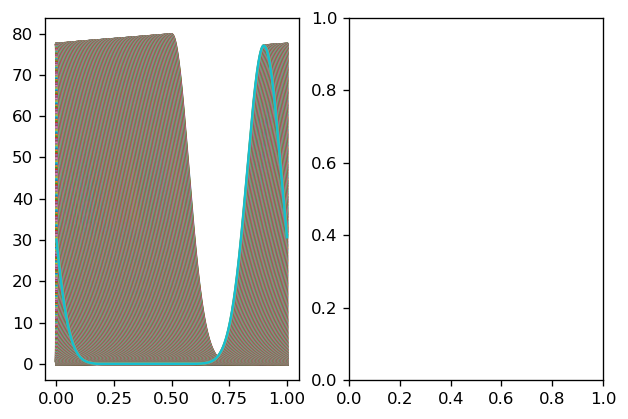

In [73]:
# time axis explicit integration
N = 1000
Dt = 3e-5
time = np.zeros(N, dtype = np.float64 )
for j in range(0, N):
    
    time[j] = j * Dt

I = 1000
    
xi = np.arange(0.0, 1.0 + 1.0 / (I+1), 1.0 / (I) )
x = xi

# getting cell volumes
Dx = x[1:] - x[:I]

# initial condition
sigma = 0.005
centers = np.zeros(I, dtype = np.float64)
centers = x[:I] + (x[1:] - x[:I])
initial_cond = np.exp( -(centers - 0.5) ** 2 / (2 * sigma)  ) / (sigma * np.sqrt(2*np.pi))

# linear function as driving field defined also on cell centers
g = 2 * centers

M = 1e1

sol, sim_time, solint = solver( I, N, initial_cond, Dx, Dt, M, g )

fig = plt.figure(dpi = 120)

ax1 = fig.add_subplot(1,2,1)

ax1.plot(centers, sol)

#ax1.plot(centers, sol[:,-1], lw = 2, color = "red")

ax2 = fig.add_subplot(1,2,2)

#ax2.plot(time, solint)

plt.show()

In [83]:
%%timeit
residual(sol[:,0], sol[:,100], g, Dx, D, I, Dt, M )

405 µs ± 43.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
